In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from nengo.dists import Uniform
import nengo
import math
from stp_ocl_implementation import *
import os, inspect
from nengo_extras.plot_spikes import plot_spikes, preprocess_spikes
import nengo.processes
import pyopencl as cl

In [2]:

#loads images in imagearr (images created using the psychopy package)
N=2000
diameter=col=row=128  #width and height of images
angles=np.arange(-90,90,1)  #angle of the grating, 999 is the bullseye 'ping'
#angles=np.append(angles, 999)
phases=np.arange(0,1,0.1)
imagearr=np.zeros((0,diameter**2))

for phase in phases:
    for angle in angles:
        name="Stimuli/stim"+str(angle)+"_"+str(round(phase,1))+".png"
        img=Image.open(name)
        img=np.array(img.convert('L'))
        imagearr=np.vstack((imagearr,img.ravel()))

name="Stimuli/stim999.png"
img=Image.open(name)
img=np.array(img.convert('L'))
imagearr=np.vstack((imagearr,img.ravel())) 
#normalize to be between -1 and 1
imagearr=imagearr/255
imagearr=2 * imagearr - 1

#generate gabor filters    
from nengo_extras.vision import Gabor, Mask
gabors = Gabor().generate(N, (col/3, row/3))#.reshape(N, -1)
gabors = Mask((col, row)).populate(gabors, flatten=True).reshape(N, -1)
gabors=gabors/abs(max(np.amax(gabors),abs(np.amin(gabors))))

#array to use for SVD
x=np.vstack((imagearr,gabors))    
      

#Do SVD    
U, S, V = np.linalg.svd(x.T)
print("SVD done")



SVD done


In [3]:
bases = 24
#Use result of SVD to create encoders
e = np.dot(gabors, U[:,:bases]) 
compressed_im=np.dot(imagearr[:1800,:]/100, U[:,:bases])

F=np.arange(-90,90,1)
Fa=F
for i in range(0,9):
    Fa=np.append(Fa,F)

Frad=(Fa/90)*math.pi
Sin=np.sin(Frad)
Cos=np.cos(Frad)
answers=np.vstack((Sin,Cos))
#set default input
stim = 0
probe = 0 

def reactivate_func(t):
    if t>1.400 and t<1.42 and cued==True:
        return np.ones(N)*0.0200
    else:
        return np.zeros(N)

#input functions


def input_func3(t):
    #t=t-.05
    if t > 0 and t < 0.25:
        return imagearr[stim,:]/100
    elif t > 2.15 and t < 2.25:
        return imagearr[1800,:]/50
    elif t > 2.65 and t < 2.90:
        return imagearr[probe,:]/100
    else:
        return np.zeros(128*128) 
    

In [10]:
with nengo.Network(seed=1) as model:
        
           
         #input nodes   
        inputNode=nengo.Node(input_func3)     
        reactivate=nengo.Node(reactivate_func)  
        
        #sensory and memory ensemble
        sensory = nengo.Ensemble(N, bases, encoders=e, intercepts=Uniform(0.01, .1),radius=1)
        memory = nengo.Ensemble(N, bases,neuron_type=stpLIF(), intercepts=Uniform(0.01, .1),radius=1)
     
        #input connection
        nengo.Connection(inputNode,sensory,transform=U[:,:bases].T)
        nengo.Connection(reactivate,memory.neurons)
        
        #connect sensory to memory
        nengo.Connection(sensory, memory, transform=.1)
       
        #learning connection (memory to memory)
        nengo.Connection(memory, memory,transform=1,learning_rule_type=STP(),solver=nengo.solvers.LstsqL2(weights=True))
        
        #decision represents sin, cosine of theta of both sensory and memory ensemble
        decision = nengo.Ensemble(n_neurons=2000, dimensions=4,radius=math.sqrt(2),intercepts=Uniform(.01, 1))
        
        #connect memory and sensory to decision
        nengo.Connection(memory, decision[2:],eval_points=compressed_im,function=answers.T)
        nengo.Connection(sensory, decision[:2],eval_points=compressed_im,function=answers.T)
    
        #create eval points so that we can go from sine and cosine of theta in sensory and memory layer
        #to the difference in theta between the two
        samples=10000
        sinAcosA=nengo.dists.UniformHypersphere(surface=True).sample(samples,2)
        thetaA=np.arctan2(sinAcosA[:,0],sinAcosA[:,1])
        thetaDiff=(90*np.random.random(samples)-45)/180*np.pi
        thetaB=thetaA+thetaDiff
        sinBcosB=np.vstack((np.sin(thetaB),np.cos(thetaB)))
        scale=np.random.random(samples)*0.9+0.1
        sinBcosB=sinBcosB*scale
        ep=np.hstack((sinAcosA,sinBcosB.T))
        
        #continuous variant of arctan(a,b)-arctan(c,d)
        def arctan_func(v):
            yA, xA, yB, xB=v
            z = np.arctan2(yA, xA) - np.arctan2(yB, xB)
            pos_ans = [z, z+2*np.pi, z-2*np.pi]
            i = np.argmin(np.abs(pos_ans))
            return pos_ans[i]*90/math.pi
        
           
        #output_ens represents the difference in theta decoded from the sensory and memory ensembles
        output_ens = nengo.Ensemble(n_neurons=2000,  dimensions=1,radius=45)
        #connect decision to output_ens
        nengo.Connection(decision, output_ens, eval_points=ep, scale_eval_points=False, function=arctan_func)

        #probes
        p_dtheta=nengo.Probe(output_ens, synapse=0.01)
        p_mem=nengo.Probe(memory, synapse=0.01)
        p_sen=nengo.Probe(sensory, synapse=0.01)
        p_spikes_mem=nengo.Probe(memory.neurons, 'spikes')
        p_res=nengo.Probe(memory.neurons, 'resources')
        p_cal=nengo.Probe(memory.neurons, 'calcium')

         


In [5]:
#Set context!!
platform = cl.get_platforms()[0]   #select platform, should be 0
device=platform.get_devices()[0]   #select GPU, use 0 (Nvidia 1) or 1 (Nvidia 3)
context=cl.Context([device])


In [6]:
def norm_p(p):
    if p<0:
        return 180+p
    if p>180:
        return p-180
    else:
        return p
   

In [11]:
cued=True
phase=0
Stim=90+phase
probe=132+phase
with StpOCLsimulator(network=model, context=context,seed=i) as sim:
    sim.run(3)
sp_c=sim.data[p_spikes_mem]
res_c=np.mean(sim.data[p_res][:,:,],1)
cal_c=np.mean(sim.data[p_cal][:,:,],1)

cued=False

with StpOCLsimulator(network=model, context=context,seed=i) as sim:
    sim.run(3)
sp_u=sim.data[p_spikes_mem]
res_u=np.mean(sim.data[p_res][:,:,],1)
cal_u=np.mean(sim.data[p_cal][:,:,],1)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [12]:
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import sorted_neurons
indices = sorted_neurons(memory, sim, iterations=250)
r=sim.data[p_spikes_mem][:,indices]
nonzero_col_indices =[i for i in range(0,r.shape[1]) if not np.allclose(r[:,i],0)]
r_new = r[:,nonzero_col_indices,]

In [13]:
from matplotlib import style
from plotnine import *
theme = theme_classic()
plt.style.use('default')
#plt.style.use('ggplot')

In [14]:
from numpy import genfromtxt
mem_cued= abs(genfromtxt('mem_cued.csv', delimiter=',')[:,1:])
mem_uncued=abs(genfromtxt('mem_uncued.csv', delimiter=',')[:,1:])
sen_cued=abs(genfromtxt('sen_cued.csv', delimiter=',')[:,1:])
sen_uncued=abs(genfromtxt('sen_uncued.csv', delimiter=',')[:,1:])

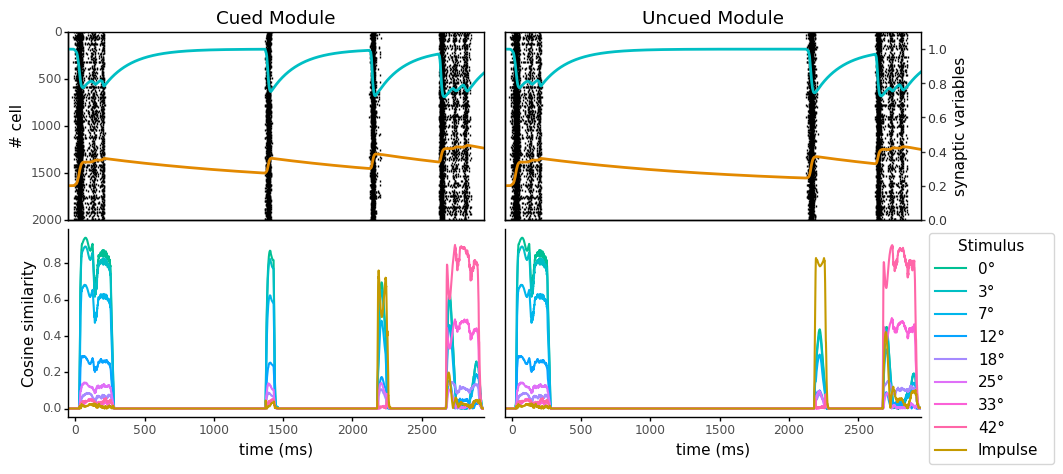

In [15]:
#FIGURE 31

with plt.rc_context():
    plt.rcParams.update(theme.rcParams)
    
    fig, axes, = plt.subplots(2,2,squeeze=True)
    theme.setup_figure(fig)
    t = sim.trange()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    ax1=axes[0,0]
    ax1.set_title("Cued Module")
    ax1.set_ylabel('# cell', color='black')
    ax1.set_yticks(np.arange(0,2500,500))
    ax1.tick_params('y')#, colors='black')
    rasterplot(sim.trange(), sp_c,ax1,colors=['black']*sp_c.shape[0])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set_xlim(0,3)
    ax2 = ax1.twinx()
    ax2.plot(t, res_c, "#00bfc4",linewidth=2)
    ax2.plot(t, cal_c, "#e38900",linewidth=2)

    ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax2.set_ylim(0,1.1)

    ax3=axes[0,1]
    ax3.set_title("Uncued Module")
    rasterplot(sim.trange(), sp_u,ax3,colors=['black']*sp_u.shape[0])
    ax3.set_xticklabels([])
    ax3.set_xticks([])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.set_xlim(0,3)
    ax4 = ax3.twinx()
    ax4.plot(t, res_u, "#00bfc4",linewidth=2)
    ax4.plot(t, cal_u, "#e38900",linewidth=2)
    ax4.set_ylabel('synaptic variables', color="black",size=11)
    ax4.tick_params('y', labelcolor='#333333',labelsize=9,color='#333333')
    ax4.set_ylim(0,1.1)



    plot_mc=axes[1,0]
    plot_mc.plot(sim.trange(),(mem_cued));

    plot_mc.set_ylabel("Cosine similarity")
    plot_mc.set_xticks(np.arange(0.05,3.5,0.5))
    plot_mc.set_xticklabels(np.arange(0,3500,500).tolist())
    plot_mc.set_xlabel('time (ms)')
    plot_mc.set_xlim(0,3)
    colors=["#00c094","#00bfc4","#00b6eb","#06a4ff","#a58aff","#df70f8","#fb61d7","#ff66a8", "#c49a00"]
    for i,j in enumerate(plot_mc.lines):
        j.set_color(colors[i])

    plot_mu=axes[1,1]

    plot_mu.plot(sim.trange(),(mem_uncued));
    plot_mu.set_xticks(np.arange(0.05,3.5,0.5))
    plot_mu.set_xticklabels(np.arange(0,3500,500).tolist())
    plot_mu.set_xlabel('time (ms)')
    plot_mu.set_yticks([])
    plot_mu.set_yticklabels([])
    plot_mu.set_xlim(0,3)
    for i,j in enumerate(plot_mu.lines):
        j.set_color(colors[i])
    plot_mu.legend(["0°","3°","7°","12°","18°","25°","33°","42°", "Impulse"], title="Stimulus", bbox_to_anchor=(1.02, -0.25, .30, 0.8), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)


    fig.set_size_inches(11, 5)
    theme.apply(plt.gcf().axes[0])
    theme.apply(plt.gcf().axes[1])
    theme.apply(plt.gcf().axes[2])
    theme.apply(plt.gcf().axes[3])
    plt.savefig('overview.eps', format='eps', dpi=1000)
    plt.show()

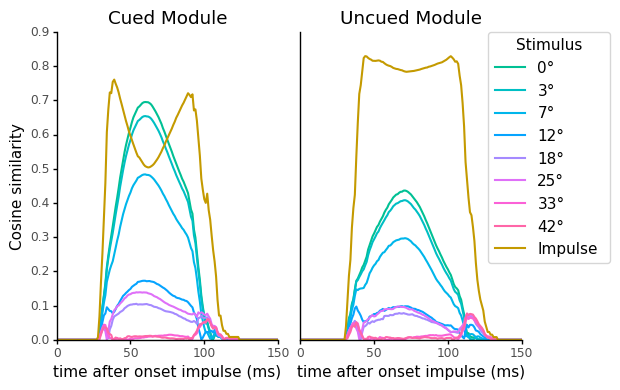

In [16]:
#FIGURE 32
with plt.rc_context():
    plt.rcParams.update(theme.rcParams)
    
    fig, axes, = plt.subplots(1,2,squeeze=True)
    theme.setup_figure(fig)
    t = sim.trange()
    plt.subplots_adjust(wspace=0.1, hspace=0.05)

   
    plot_mc=axes[0]
    plot_mc.set_title("Cued Module")
    plot_mc.plot(sim.trange(),(mem_cued));
    plot_mc.set_ylabel("Cosine similarity")
    plot_mc.set_xticks(np.arange(2.2,2.4,0.05))
    plot_mc.set_xticklabels(np.arange(0,250,50).tolist())
    plot_mc.set_xlabel('time after onset impulse (ms)')
    plot_mc.set_xlim(2.2,2.35)
    plot_mc.set_ylim(0,0.9)
    colors=["#00c094","#00bfc4","#00b6eb","#06a4ff","#a58aff","#df70f8","#fb61d7","#ff66a8", "#c49a00"]
    for i,j in enumerate(plot_mc.lines):
        j.set_color(colors[i])



    plot_mu=axes[1]
    plot_mu.set_title("Uncued Module")
    plot_mu.plot(sim.trange(),(mem_uncued));
    plot_mu.set_xticks(np.arange(2.2,2.4,0.05))
    plot_mu.set_xticklabels(np.arange(0,250,50).tolist())
    plot_mu.set_xlabel('time after onset impulse (ms)')
    plot_mu.set_yticks([])
    plot_mu.set_yticklabels([])
    plot_mu.set_xlim(2.2,2.35)
    plot_mu.set_ylim(0,0.9)
    for i,j in enumerate(plot_mu.lines):
        j.set_color(colors[i])
    plot_mu.legend(["0°","3°","7°","12°","18°","25°","33°","42°", "Impulse"], title="Stimulus", bbox_to_anchor=(0.85, 0.25, .55, 0.8), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

    fig.set_size_inches(6, 4)

    theme.apply(plt.gcf().axes[0])
    theme.apply(plt.gcf().axes[1])
    plt.savefig('cos_impulse.eps', format='eps', dpi=1000)
    plt.show()

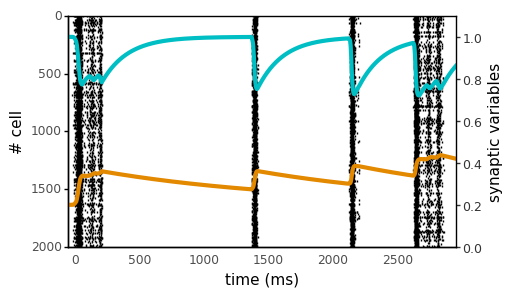

In [17]:
#FIGURE 34
#First rerun simulation with intercepts of memory layer set to (-.001, 0.1)!!!!!

with plt.rc_context():
    plt.rcParams.update(theme.rcParams)
    
    fig, ax1, = plt.subplots(1,1,squeeze=True)
    theme.setup_figure(fig)
    t = sim.trange()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    ax1.set_ylabel('# cell', color='black')
    ax1.set_yticks(np.arange(0,2500,500))
    ax1.tick_params('y')#, colors='black')
    rasterplot(sim.trange(), sp_c,ax1,colors=['black']*sp_c.shape[0])

    ax2 = ax1.twinx()
    ax2.plot(t, res_c, "#00bfc4",linewidth=3)
    ax2.plot(t, cal_c, "#e38900",linewidth=3)

    ax2.set_ylim(0,1.1)
    ax2.set_xticks(np.arange(0.05,3.5,0.5))
    ax2.set_xticklabels(np.arange(0,3500,500).tolist())
    ax1.set_xlabel('time (ms)')
    ax2.set_xlim(0,3)

    fig.set_size_inches(5, 3)

    ax2.set_ylabel('synaptic variables', color="black",size=11)
    ax2.tick_params('y', labelcolor='#333333',labelsize=9,color='#333333')
    ax2.set_ylim(0,1.1)

    theme.apply(plt.gcf().axes[0])
    plt.savefig('spike2.eps', format='eps', dpi=1000)
    plt.show()